# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(dataset_file_name="twitter_filtered.csv", labels_file_name="twitter_labels_filtered.csv", 
                                          labels_map=labels, limit=5000000) # Loads filtered dataset.
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
2320975


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
#for i in range(10):
twitter_config._name = "twitter_" + "linksProbability_"# + str(i) + "_"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path, 
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000}, 
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'auc': 0.8905526, 'recall': 0.9236000000000001, 'precision': 0.7834575850675484, 'accuracy': 0.8336, 'fpr': 0.2564000000000001, 'tnr': 0.7436}
Validate_prediction_by_links: {'auc': 1.0, 'recall': 0.24444444444444444, 'precision': 0.055, 'accuracy': 0.8986363636363637, 'fpr': 0.08770301624129931}


In [7]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [8]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [9]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [10]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
3802,2104351,0.042308,13.0,0.957692,1.000000,13.0,1.0,1.0,1.0,1
3456,946314,0.126184,13.0,0.873816,1.000000,13.0,1.0,0.0,1.0,2
3152,709798,0.305895,19.0,0.694105,1.000000,19.0,1.0,0.0,1.0,3
3830,2424868,0.224701,22.0,0.775299,0.954545,21.0,1.0,0.0,1.0,4
3462,955631,0.075796,18.0,0.924204,0.944444,17.0,1.0,0.0,1.0,5
1850,215522,0.276627,14.0,0.723373,0.928571,13.0,1.0,1.0,2.0,6
2398,352725,0.279480,13.0,0.720520,0.923077,12.0,1.0,1.0,3.0,7
1849,215410,0.278454,12.5,0.721546,0.919872,11.5,1.0,1.0,4.0,8
3686,1455795,0.218845,24.0,0.781155,0.895833,21.5,1.0,0.5,4.5,9
3398,880719,0.287188,16.0,0.712813,0.875000,14.0,1.0,1.0,5.5,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [11]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [12]:
df[["k", "p@k"]].head(10)

,k,p@k
3802,1,1.000000
3456,2,0.500000
3152,3,0.333333
3830,4,0.250000
3462,5,0.200000
1850,6,0.333333
2398,7,0.428571
1849,8,0.500000
3686,9,0.500000
3398,10,0.550000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

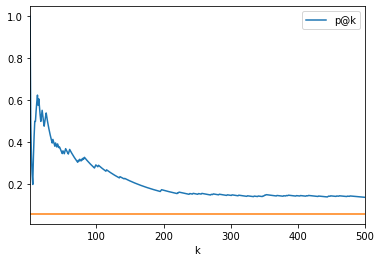

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))

## Logistic Regression

In [14]:
twitter_config._name = "twitter_" + "LogisticRegression_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_logistic_regression_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'auc': 0.8985951999999999, 'recall': 0.9288000000000001, 'precision': 0.7938346484693222, 'accuracy': 0.8436999999999999, 'fpr': 0.24139999999999998, 'tnr': 0.7585999999999999}


## Random Forest

In [20]:
twitter_config._name = "twitter_" + "RandomForest_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_randomforest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'auc': 0.8812744, 'recall': 0.9336, 'precision': 0.7863304664756144, 'accuracy': 0.8399000000000001, 'fpr': 0.2538, 'tnr': 0.7462}


## Isolation Forest

In [21]:
twitter_config._name = "twitter_" + "IsolationForest_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_isolation_forest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'auc': 0.8771406, 'recall': 0.9316000000000001, 'precision': 0.7862578974315231, 'accuracy': 0.8391, 'fpr': 0.25339999999999996, 'tnr': 0.7465999999999999}
